In [1]:
import os
import skimage
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from torchvision import transforms
from collections import OrderedDict
import torch
import clip
from torchvision.datasets import CIFAR100
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [2]:
# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('ViT-B/32', device)

# Download the dataset
cifar100 = CIFAR100(root=os.path.expanduser("~/.cache"), download=True, train=False)


Files already downloaded and verified


Accuracy at step 1: 0.00%
Accuracy at step 2: 0.00%
Accuracy at step 3: 0.00%
Accuracy at step 4: 25.00%
Accuracy at step 5: 40.00%
Accuracy at step 6: 50.00%
Accuracy at step 7: 57.14%
Accuracy at step 8: 50.00%
Accuracy at step 9: 44.44%
Accuracy at step 10: 50.00%
Accuracy at step 11: 45.45%
Accuracy at step 12: 50.00%
Accuracy at step 13: 53.85%
Accuracy at step 14: 57.14%
Accuracy at step 15: 60.00%
Accuracy at step 16: 62.50%
Accuracy at step 17: 64.71%
Accuracy at step 18: 61.11%
Accuracy at step 19: 63.16%
Accuracy at step 20: 65.00%
Accuracy at step 21: 66.67%
Accuracy at step 22: 68.18%
Accuracy at step 23: 69.57%
Accuracy at step 24: 70.83%
Accuracy at step 25: 72.00%
Accuracy at step 26: 73.08%
Accuracy at step 27: 74.07%
Accuracy at step 28: 75.00%
Accuracy at step 29: 75.86%
Accuracy at step 30: 73.33%
Accuracy at step 31: 74.19%
Accuracy at step 32: 75.00%
Accuracy at step 33: 75.76%
Accuracy at step 34: 73.53%
Accuracy at step 35: 74.29%
Accuracy at step 36: 72.22%
Accu

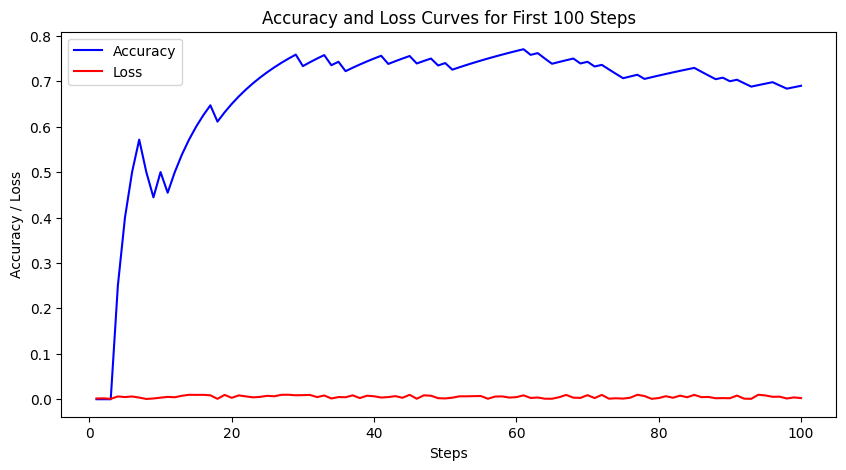

In [4]:
# Prepare the lists to store accuracy and loss values
accuracies = []
losses = []
testing_num = 0
testing_right = 0

with torch.no_grad():
    model.eval()

    for index in range(len(cifar100)):
        if testing_num >= 100:  # Stop after 100 steps
            break

        image, label = cifar100[index]
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_input = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        value, predict = similarity[0].topk(1)
        loss = value.item() * 0.01
#         testing_loss.append(loss)
        
        if predict == label:
            testing_right += 1
        
        current_accuracy = testing_right / (testing_num + 1)
        accuracies.append(current_accuracy)  # Append current accuracy to the list
        losses.append(loss)  # Append current loss to the list
        print(f"Accuracy at step {testing_num + 1}: {current_accuracy * 100:.2f}%")
            
        testing_num += 1

# Plotting accuracy and loss curves for the first 100 steps
plt.figure(figsize=(10, 5))

plt.plot(range(1, len(accuracies) + 1), accuracies, label='Accuracy', color='blue')
plt.plot(range(1, len(losses) + 1), losses, label='Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Accuracy / Loss')
plt.title('Accuracy and Loss Curves for First 100 Steps')
plt.legend()

plt.show()


Prediction at step 1: 58, True label: 49
Prediction at step 2: 41, True label: 33
Prediction at step 3: 59, True label: 72
Prediction at step 4: 51, True label: 51
Prediction at step 5: 71, True label: 71
Prediction at step 6: 92, True label: 92
Prediction at step 7: 15, True label: 15
Prediction at step 8: 47, True label: 14
Prediction at step 9: 60, True label: 23
Prediction at step 10: 0, True label: 0
Prediction at step 11: 59, True label: 71
Prediction at step 12: 75, True label: 75
Prediction at step 13: 81, True label: 81
Prediction at step 14: 69, True label: 69
Prediction at step 15: 40, True label: 40
Prediction at step 16: 43, True label: 43
Prediction at step 17: 92, True label: 92
Prediction at step 18: 15, True label: 97
Prediction at step 19: 70, True label: 70
Prediction at step 20: 53, True label: 53
Prediction at step 21: 70, True label: 70
Prediction at step 22: 49, True label: 49
Prediction at step 23: 75, True label: 75
Prediction at step 24: 29, True label: 29
Pre

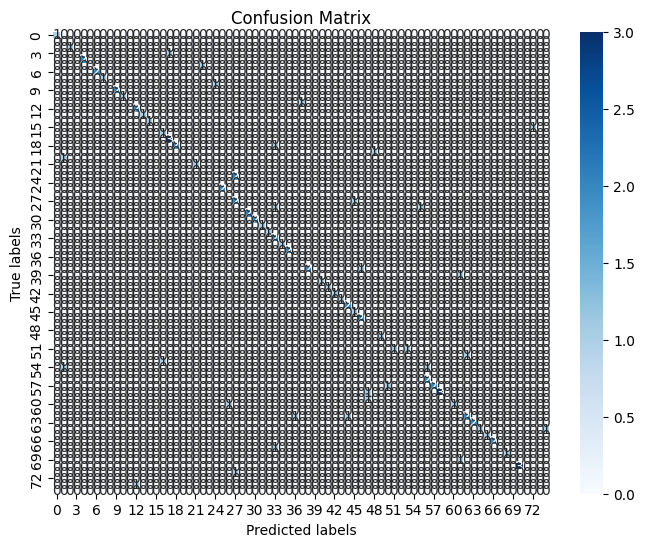

In [5]:


# Load the model, preprocess, and obtain predictions and labels

predictions = []  # Store the predicted labels
true_labels = []  # Store the true labels

with torch.no_grad():
    model.eval()

    for index in range(len(cifar100)):
        if len(predictions) >= 100:  # Stop after 100 steps
            break

        image, label = cifar100[index]
        image_input = preprocess(image).unsqueeze(0).to(device)
        text_input = torch.cat([clip.tokenize(f"a photo of a {c}") for c in cifar100.classes]).to(device)

        with torch.no_grad():
            image_features = model.encode_image(image_input)
            text_features = model.encode_text(text_input)

        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        similarity = (100.0 * image_features @ text_features.T).softmax(dim=-1)
        value, predict = similarity[0].topk(1)
        
        predictions.append(predict.item())  # Append the predicted label
        true_labels.append(label)  # Append the true label
        
        print(f"Prediction at step {len(predictions)}: {predict.item()}, True label: {label}")

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predictions)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()


Epoch 1/50
782/782 [==============================] - 9s 9ms/step - loss: 4.0229 - accuracy: 0.0864 - val_loss: 3.6066 - val_accuracy: 0.1472
Epoch 2/50
782/782 [==============================] - 6s 8ms/step - loss: 3.4057 - accuracy: 0.1853 - val_loss: 3.2623 - val_accuracy: 0.2178
Epoch 3/50
782/782 [==============================] - 6s 8ms/step - loss: 3.0846 - accuracy: 0.2444 - val_loss: 3.0037 - val_accuracy: 0.2608
Epoch 4/50
782/782 [==============================] - 7s 8ms/step - loss: 2.8834 - accuracy: 0.2825 - val_loss: 2.8656 - val_accuracy: 0.2881
Epoch 5/50
782/782 [==============================] - 7s 8ms/step - loss: 2.7498 - accuracy: 0.3096 - val_loss: 2.8457 - val_accuracy: 0.2954
Epoch 6/50
782/782 [==============================] - 7s 9ms/step - loss: 2.6538 - accuracy: 0.3293 - val_loss: 2.7261 - val_accuracy: 0.3216
Epoch 7/50
782/782 [==============================] - 7s 8ms/step - loss: 2.5691 - accuracy: 0.3468 - val_loss: 2.8232 - val_accuracy: 0.3075
Epoch 

<Figure size 1000x800 with 0 Axes>

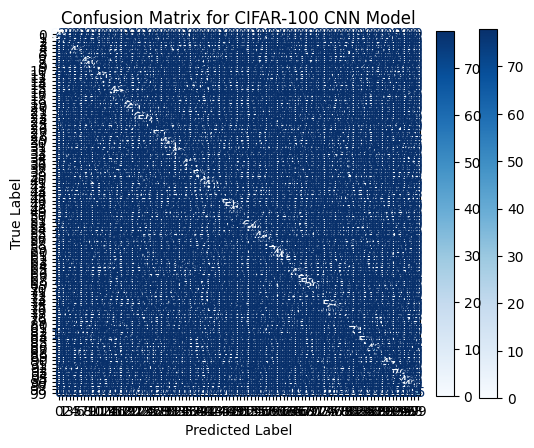

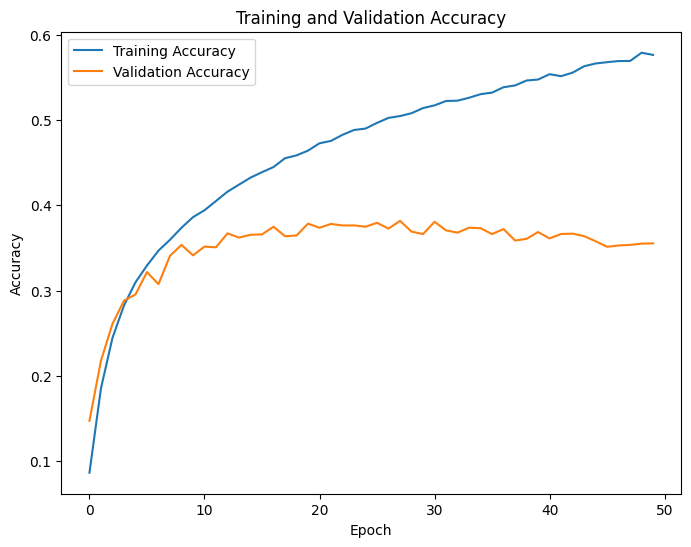

In [8]:
import tensorflow as tf
from tensorflow.keras.datasets import cifar100
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

# Data preprocessing
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Build the CNN model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(100, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Train the model and get the history
history = model.fit(train_images, train_labels, epochs=50, batch_size=64, verbose=1, validation_data=(test_images, test_labels))

# Make predictions using the model
predictions = model.predict(test_images)
predicted_labels = tf.argmax(predictions, axis=1)

# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, predicted_labels)

# Display the confusion matrix
plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=range(100))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title('Confusion Matrix for CIFAR-100 CNN Model')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# Show the colorbar
plt.colorbar(disp.im_, fraction=0.046, pad=0.04)
plt.show()

# Plotting accuracy curve
plt.figure(figsize=(8, 6))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()
